In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
def preprocess_df(df):
    skuId = 3553 # Выбираем миниральную воду
    df = df[df.skuId == skuId]
    
    df_19_20 = pd.read_csv("skuid 03553 in 19-20.csv", sep=';', encoding='windows-1251')
    df_19_20.rename(columns={'п»їshopId':'shopId'}, inplace=True)
    df = pd.concat([df, df_19_20], axis=0)
    
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['date'] = pd.to_datetime(df['date'])
    df['finishDate'] = pd.to_datetime(df['finishDate'])
    
    df['sales'] = df['sales'].astype(int)
    df['salesRub'] = df['salesRub'].str.replace(',', '.').astype(float)
    
    cond = (df.promoId.notna())
    df['discont'] = df[cond]['discont'].str.replace(',', '.').astype(float)
    df['price'] = df[cond]['price'].str.replace(',', '.').astype(float)

    del df['statusPromo']
    del df['typePromo']
    del df['priceAkcia']
    df = df.reset_index(drop=True)
    return df

In [3]:
def feature_engeniring(df):
    df['price'] = df['salesRub'] / df['sales']
    
    # номер месяца
    df['block_num'] = df.date.apply(lambda row: row.month + (row.year - 2017) * 12)
    
    # процент изменения цены в акции
    df['percentage_price_change'] = 0.
    df.reset_index(drop=True, inplace=True)
    cond = (df.promoId.notna())
    df.loc[cond, 'percentage_price_change'] = df.discont * 100 / df.price
    df = df.groupby(['block_num', 'shopId'])['percentage_price_change'].max().reset_index().merge(df.drop(['percentage_price_change'], axis=1), on=['block_num', 'shopId'], how='inner')
    
    # кол-во акций в месяце
    q = df.groupby(['block_num', 'shopId'])['startDate'].nunique().reset_index()
    q.rename(columns={'startDate': 'promo_num_month'}, inplace=True)
    df = pd.merge(df, q, how = 'inner', on=['block_num', 'shopId'])
    
    # кол-во дней в месяце с акцией
    from calendar import monthrange
    cond = (df.promoId.notna())
    t = df[cond].apply(lambda row: (row.finishDate  - row.startDate).days if row.finishDate.month == row.startDate.month else (monthrange(row.startDate.year, row.startDate.month)[1] - row.startDate.day), axis=1)
    df = df.join(t.rename("num_of_promo_days_month").to_frame())
    df['num_of_promo_days_month'] = df['num_of_promo_days_month'].fillna(0)
    df = df.groupby(['block_num', 'shopId'])['num_of_promo_days_month'].max().reset_index().merge(df.drop(['num_of_promo_days_month'], axis=1), on=['block_num', 'shopId'], how='inner')
    
    return df

In [4]:
df = pd.read_csv("final table.csv", sep=';', encoding='windows-1251')
df = preprocess_df(df)
df = feature_engeniring(df)

In [5]:
def print_df(df):
    display(df.head()) 
    display(df.tail())
    display(df.sample(10))
print_df(df)

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,170,0.0,0.0,3553,1,38.7,2017-01-06,NaN,NaT,NaT,38.7,NaN,0
1,1,170,0.0,0.0,3553,1,38.7,2017-01-06,NaN,NaT,NaT,38.7,NaN,0
2,1,170,0.0,0.0,3553,2,77.4,2017-01-07,NaN,NaT,NaT,38.7,NaN,0
3,1,170,0.0,0.0,3553,1,38.7,2017-01-06,NaN,NaT,NaT,38.7,NaN,0
4,1,170,0.0,0.0,3553,1,38.7,2017-01-07,NaN,NaT,NaT,38.7,NaN,0


,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
47897,39,174,10.0,51.310345,3553,1,43.5,2020-03-15,NaN,NaT,NaT,43.5,NaN,1
47898,39,174,10.0,51.310345,3553,1,43.5,2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47899,39,174,10.0,51.310345,3553,1,43.5,2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47900,39,174,10.0,51.310345,3553,1,43.5,2020-03-11,NaN,NaT,NaT,43.5,NaN,1
47901,39,174,10.0,51.310345,3553,2,87.0,2020-03-15,NaN,NaT,NaT,43.5,NaN,1


,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
27459,23,174,0.0,0.000000,3553,4,159.6,2018-11-17,NaN,NaT,NaT,39.9,NaN,0
4001,4,174,0.0,0.000000,3553,1,38.7,2017-04-15,NaN,NaT,NaT,38.7,NaN,0
25910,22,172,13.0,74.887218,3553,1,39.9,2018-10-22,SLAT-170000409,2018-10-17,2018-10-30,39.9,29.88,1
23253,19,174,0.0,0.000000,3553,2,109.8,2018-07-17,NaN,NaT,NaT,54.9,NaN,0
35111,29,172,6.0,46.971047,3553,2,89.8,2019-05-01,SLAT-170001783,2019-04-24,2019-05-07,44.9,21.09,1
30621,25,173,5.0,74.887218,3553,1,53.5,2019-01-27,NaN,NaT,NaT,53.5,NaN,1
15698,14,173,0.0,0.000000,3553,2,101.8,2018-02-06,NaN,NaT,NaT,50.9,NaN,0
6334,6,173,0.0,0.000000,3553,1,45.9,2017-06-01,NaN,NaT,NaT,45.9,NaN,0
42135,35,170,0.0,0.000000,3553,1,43.5,2019-11-14,NaN,NaT,NaT,43.5,NaN,0
29913,25,172,5.0,74.887218,3553,1,39.9,2019-01-11,SLAT-170000628,2018-12-26,2019-01-15,39.9,29.88,1


In [6]:
def day_aggregating(df, shopId=174, no_promo=False):
    df_174 = df.copy()
    df_174 = df_174[df_174.shopId==shopId]
    df_174.reset_index(drop=True, inplace=True)

    dates = pd.date_range(start=df_174.date.min().strftime('%Y-%m-%d'), \
              end=df_174.date.max().strftime('%Y-%m-%d'), freq='d')

    ts = pd.DataFrame({'Dates': dates})
    if no_promo:
        df_174 = df_174[df_174.promoId.isna()] 
        
    ts_174 = df_174.groupby('date')['sales'].sum()

    temp = df_174.groupby('date')[['percentage_price_change', 'num_of_promo_days_month', 'shopId', \
                                  'promoId', 'startDate', 'finishDate', 'price', 'discont', 'promo_num_month']].max()
    ts_174 = ts_174.to_frame().merge(temp, on='date')

    ts = ts.rename(columns={'Dates': 'date'})
    ts = ts.merge(ts_174.reset_index(), on='date', how='left')
    
    ts['sales'] = ts['sales'].fillna(0)
    ts['promo_num_month'] = ts['promo_num_month'].fillna(method='backfill')
    ts['price'] = ts['price'].fillna(method='backfill')
    ts['shopId'] = ts['shopId'].fillna(method='backfill')
    ts['num_of_promo_days_month'] = ts['num_of_promo_days_month'].fillna(method='backfill')
    ts['percentage_price_change'] = ts['percentage_price_change'].fillna(method='backfill')
    ts['startDate'] = ts['startDate'].fillna(method='backfill')
    ts['finishDate'] = ts['finishDate'].fillna(method='backfill')
    ts['discont'] = ts['discont'].fillna(method='backfill')
    
    if no_promo:
        ts.drop(['promo_num_month', 'num_of_promo_days_month', 'percentage_price_change', 'finishDate',\
                 'discont', 'startDate', 'promoId'], axis=1, inplace=True)
    
    return ts

In [7]:
df_174 = df[df.shopId==173]
df_174.reset_index(drop=True, inplace=True)
df_174.shape

(11575, 14)

In [8]:
df_174[df_174.promoId.isna()]

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,173,0.0,0.000000,3553,1,50.7,2017-01-06,NaN,NaT,NaT,50.7,NaN,0
1,1,173,0.0,0.000000,3553,1,50.7,2017-01-06,NaN,NaT,NaT,50.7,NaN,0
2,1,173,0.0,0.000000,3553,1,44.9,2017-01-07,NaN,NaT,NaT,44.9,NaN,0
3,1,173,0.0,0.000000,3553,1,44.9,2017-01-07,NaN,NaT,NaT,44.9,NaN,0
4,1,173,0.0,0.000000,3553,1,44.9,2017-01-07,NaN,NaT,NaT,44.9,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,39,173,10.0,8.336449,3553,1,53.5,2020-03-03,NaN,NaT,NaT,53.5,NaN,1
11569,39,173,10.0,8.336449,3553,1,53.5,2020-03-15,NaN,NaT,NaT,53.5,NaN,1
11570,39,173,10.0,8.336449,3553,1,53.5,2020-03-15,NaN,NaT,NaT,53.5,NaN,1
11573,39,173,10.0,8.336449,3553,2,107.0,2020-03-11,NaN,NaT,NaT,53.5,NaN,1


In [9]:
dates = pd.date_range(start=df_174.date.min().strftime('%Y-%m-%d'), \
              end=df_174.date.max().strftime('%Y-%m-%d'), freq='d')

ts = pd.DataFrame({'Dates': dates})

In [10]:
ts.shape

(1181, 1)

агрегируем по дням

In [11]:
ts_174 = df_174.groupby('date')['sales'].sum()

temp = df_174.groupby('date')[['percentage_price_change', 'num_of_promo_days_month', 'shopId', \
                              'promoId', 'startDate', 'finishDate', 'price', 'discont', 'promo_num_month']].max()
ts_174 = ts_174.to_frame().merge(temp, on='date')

In [12]:
print_df(ts_174)

,sales,percentage_price_change,num_of_promo_days_month,shopId,startDate,finishDate,price,discont,promo_num_month
date,,,,,,,,,
2017-01-04,17,0.0,0.0,173,NaT,NaT,50.7,NaN,0
2017-01-05,11,0.0,0.0,173,NaT,NaT,50.7,NaN,0
2017-01-06,9,0.0,0.0,173,NaT,NaT,50.7,NaN,0
2017-01-07,43,0.0,0.0,173,NaT,NaT,44.9,NaN,0
2017-01-08,22,0.0,0.0,173,NaT,NaT,53.9,NaN,0


,sales,percentage_price_change,num_of_promo_days_month,shopId,startDate,finishDate,price,discont,promo_num_month
date,,,,,,,,,
2020-03-25,12,8.336449,10.0,173,2020-03-21,2020-06-01,53.5,4.46,1
2020-03-26,11,8.336449,10.0,173,2020-03-21,2020-06-01,53.5,4.46,1
2020-03-27,23,8.336449,10.0,173,2020-03-21,2020-06-01,53.5,4.46,1
2020-03-28,26,8.336449,10.0,173,2020-03-21,2020-06-01,53.5,4.46,1
2020-03-29,13,8.336449,10.0,173,2020-03-21,2020-06-01,53.5,4.46,1


,sales,percentage_price_change,num_of_promo_days_month,shopId,startDate,finishDate,price,discont,promo_num_month
date,,,,,,,,,
2018-01-05,15,0.000000,0.0,173,NaT,NaT,50.9,NaN,0
2019-01-26,21,74.887218,5.0,173,NaT,NaT,53.5,NaN,1
2019-02-13,16,0.000000,0.0,173,NaT,NaT,53.5,NaN,0
2019-07-04,8,0.000000,0.0,173,NaT,NaT,53.5,NaN,0
2017-10-24,25,0.000000,0.0,173,NaT,NaT,49.9,NaN,0
2017-12-29,37,0.000000,0.0,173,NaT,NaT,49.9,NaN,0
2019-11-04,6,0.000000,0.0,173,NaT,NaT,53.5,NaN,0
2019-12-09,21,83.684211,13.0,173,2019-12-04,2019-12-17,39.9,33.39,2
2020-02-04,11,55.768374,13.0,173,NaT,NaT,53.5,NaN,1


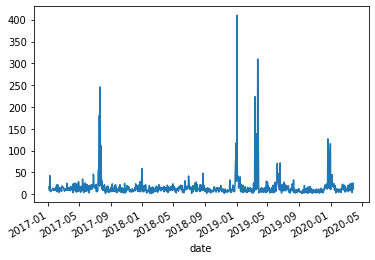

In [13]:
ts_174.sales.plot()

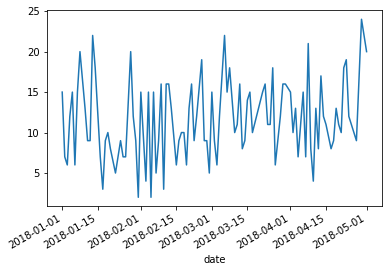

In [14]:
ts_174['2018-01-01':'2018-05-01'].sales.plot()

In [15]:
ts = ts.rename(columns={'Dates': 'date'})
ts = ts.merge(ts_174.reset_index(), on='date', how='left')

In [16]:
ts['sales'] = ts['sales'].fillna(0)
ts['promo_num_month'] = ts['promo_num_month'].fillna(method='backfill')
ts['price'] = ts['price'].fillna(method='backfill')
ts['shopId'] = ts['shopId'].fillna(method='backfill')
ts['num_of_promo_days_month'] = ts['num_of_promo_days_month'].fillna(method='backfill')
ts['percentage_price_change'] = ts['percentage_price_change'].fillna(method='backfill')
ts['startDate'] = ts['startDate'].fillna(method='backfill')
ts['finishDate'] = ts['finishDate'].fillna(method='backfill')
ts['discont'] = ts['discont'].fillna(method='backfill')

In [17]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [18]:
def prepareData(data, cat_features, lag_start=5, lag_end=20, test_size=0.15, drop_date=True):

    data = pd.DataFrame(data.copy())
    
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    data = data.reset_index()
    print(f"Тестовая выборка с {data.date[test_index]} до {data.date[data.shape[0]-1]}")
    data = data.set_index('date')

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    cat_features += ['weekday', 'is_weekend']
    for f in cat_features:
        mapping = code_mean(data, f, "y")
        data[f'{f}_average'] = data[f].apply(lambda x: mapping.get(x))

    # выкидываем закодированные средними признаки 
    for f in cat_features:
        data.drop([f], axis=1, inplace=True)

    data = data.dropna()
#     data['num_of_promo_days_month'] = data.num_of_promo_days_month.fillna(13)
    data = data.reset_index()
    if drop_date:
        data.drop(['date'], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [19]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

# Предсказание кол-во продаж с промо

In [54]:
ts = day_aggregating(df, shopId=174)

In [55]:
ts[ts.num_of_promo_days_month > 0].head(20)

,date,sales,percentage_price_change,num_of_promo_days_month,shopId,startDate,finishDate,price,discont,promo_num_month
638,2018-10-01,13.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,42.9,33.39,1.0
639,2018-10-02,0.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,42.2,29.88,1.0
640,2018-10-03,27.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,42.2,29.88,1.0
641,2018-10-04,16.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,39.9,29.88,1.0
642,2018-10-05,21.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,51.9,29.88,1.0
643,2018-10-06,85.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,39.9,29.88,1.0
644,2018-10-07,37.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,39.9,29.88,1.0
645,2018-10-08,19.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,48.9,29.88,1.0
646,2018-10-09,0.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,43.5,29.88,1.0
647,2018-10-10,14.0,74.887218,13.0,174.0,2018-10-17,2018-10-30,43.5,29.88,1.0


In [56]:
ts.tail()

,date,sales,percentage_price_change,num_of_promo_days_month,shopId,startDate,finishDate,price,discont,promo_num_month
1179,2020-03-25,17.0,51.310345,10.0,174.0,2020-03-21,2020-06-01,43.5,22.32,1.0
1180,2020-03-26,25.0,51.310345,10.0,174.0,2020-03-21,2020-06-01,43.5,22.32,1.0
1181,2020-03-27,22.0,51.310345,10.0,174.0,2020-03-21,2020-06-01,43.5,22.32,1.0
1182,2020-03-28,47.0,51.310345,10.0,174.0,2020-03-21,2020-06-01,43.5,22.32,1.0
1183,2020-03-29,43.0,51.310345,10.0,174.0,2020-03-21,2020-06-01,43.5,22.32,1.0


In [57]:
len(ts) / 100 * 3

35.519999999999996

In [58]:
data = ts.rename(columns={'sales':'y'}).set_index('date').drop(['shopId', 'startDate', 'finishDate'], axis=1)
cat_features = ['num_of_promo_days_month', 'promo_num_month']
X_train, X_test, y_train, y_test = prepareData(data, cat_features, test_size=0.03, lag_start=1, lag_end=5)

Тестовая выборка с 2020-02-23 00:00:00 до 2020-03-29 00:00:00


In [59]:
X_test.tail()

,percentage_price_change,price,discont,lag_1,lag_2,lag_3,lag_4,num_of_promo_days_month_average,promo_num_month_average,weekday_average,is_weekend_average
1175,51.310345,43.5,22.32,13.0,12.0,31.0,32.0,20.0,23.839344,22.733728,24.489941
1176,51.310345,43.5,22.32,17.0,13.0,12.0,31.0,20.0,23.839344,27.727811,24.489941
1177,51.310345,43.5,22.32,25.0,17.0,13.0,12.0,20.0,23.839344,31.313609,24.489941
1178,51.310345,43.5,22.32,22.0,25.0,17.0,13.0,20.0,23.839344,33.502959,28.935103
1179,51.310345,43.5,22.32,47.0,22.0,25.0,17.0,20.0,23.839344,24.394118,28.935103


In [60]:
len(X_test)

32

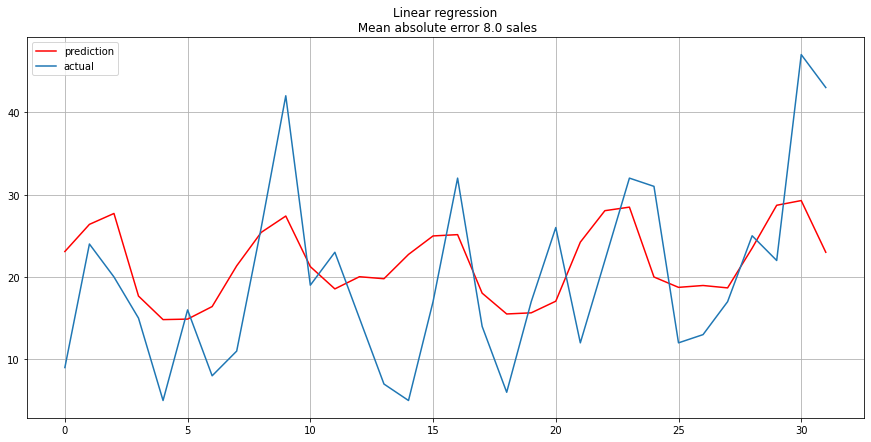

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction_promo = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction_promo, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} sales".format(round(mean_absolute_error(prediction_promo, y_test))))
plt.grid(True);

In [62]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1149, 11)
Size of each fold: 229

Splitting the first 2 chunks at 1/2
Size of train + test: (458, 11)

Splitting the first 3 chunks at 2/3
Size of train + test: (687, 11)

Splitting the first 4 chunks at 3/4
Size of train + test: (916, 11)

Splitting the first 5 chunks at 4/5
Size of train + test: (1145, 11)
CPU times: user 13.3 ms, sys: 2 µs, total: 13.3 ms
Wall time: 9.96 ms


133247613059.25862

In [63]:
import xgboost as xgb

def XGB_forecast(X_train, X_test, y_train, y_test, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
#     data = ts.rename(columns={'sales':'y'}).set_index('date').drop(['shopId', 'startDate', 'finishDate'], axis=1)
#     cat_features = ['num_of_promo_days_month', 'promo_num_month']
#     X_train, X_test, y_train, y_test = prepareData(data, cat_features, test_size=0.2, lag_start=1, lag_end=5)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear',
        "max_depth":2,
        "subsample":0.9, 
        "eta":0.05,    
        "seed":42}
    
    
    trees = 20

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
#     cv.plot(y=['test-mae-mean', 'train-mae-mean'])

#     # запоминаем ошибку на кросс-валидации
#     deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
#     lower = prediction_test-scale*deviation
#     upper = prediction_test+scale*deviation

#     Anomalies = np.array([np.NaN]*len(y_test))
#     Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
#     plt.plot(lower, "r--", label="upper bond / lower bond")
#     plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
#     plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

[19:05:05] WARNING: /workspace/src/learner.cc:328: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




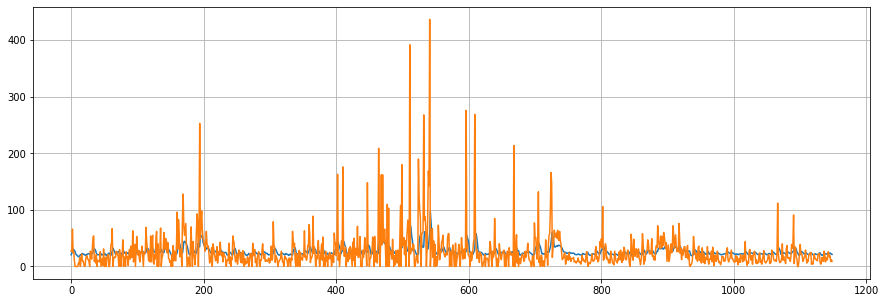

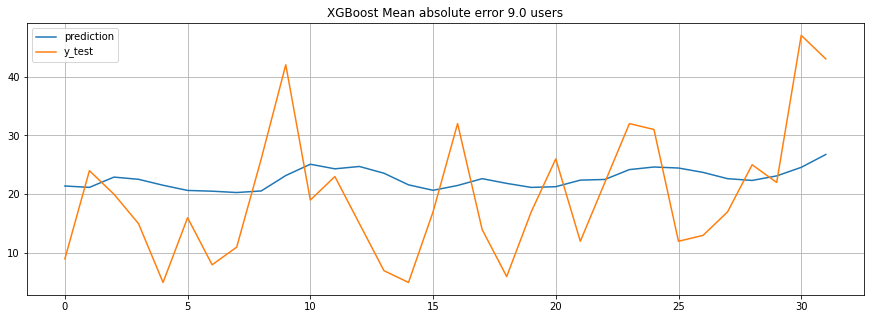

In [64]:
XGB_forecast(X_train, X_test, y_train, y_test, test_size=0.2, lag_start=1, lag_end=5)

# Предсказание кол-во продаж без промо

In [65]:
ts_174_no_promo = day_aggregating(df, no_promo=True)

In [66]:
ts_174_no_promo

,date,sales,shopId,price
0,2017-01-01,1.0,174.0,45.9
1,2017-01-02,0.0,174.0,50.7
2,2017-01-03,0.0,174.0,50.7
3,2017-01-04,24.0,174.0,50.7
4,2017-01-05,27.0,174.0,38.7
...,...,...,...,...
1179,2020-03-25,0.0,NaN,NaN
1180,2020-03-26,0.0,NaN,NaN
1181,2020-03-27,0.0,NaN,NaN
1182,2020-03-28,0.0,NaN,NaN


In [67]:
ts_174_no_promo = ts_174_no_promo[ts_174_no_promo.date < '2019-04-01']

In [68]:
len(ts_174_no_promo) / 100 * 7

57.39999999999999

In [69]:
data = ts_174_no_promo.rename(columns={'sales':'y'}).set_index('date').drop(['shopId'], axis=1)
cat_features = []
X_train, X_test, y_train, y_test = prepareData(data, cat_features, test_size=0.04, lag_start=1, lag_end=5)

Тестовая выборка с 2019-02-27 00:00:00 до 2019-03-31 00:00:00


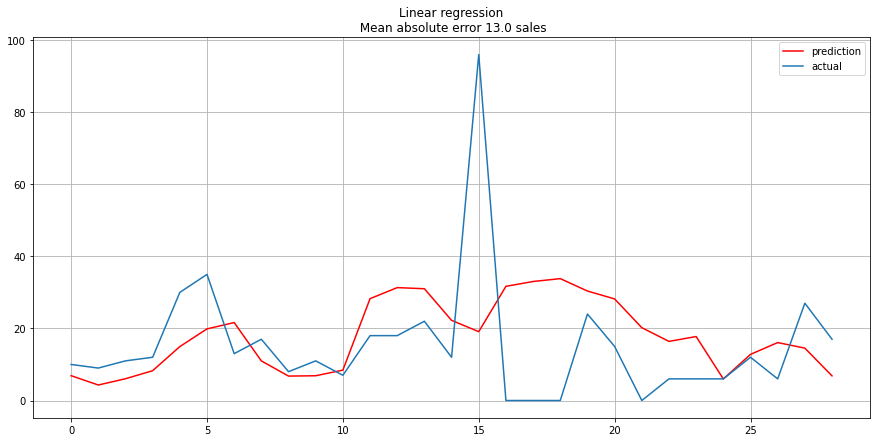

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction_no_promo = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction_no_promo, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} sales".format(round(mean_absolute_error(prediction_no_promo, y_test))))
plt.grid(True);

[19:05:06] WARNING: /workspace/src/learner.cc:328: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




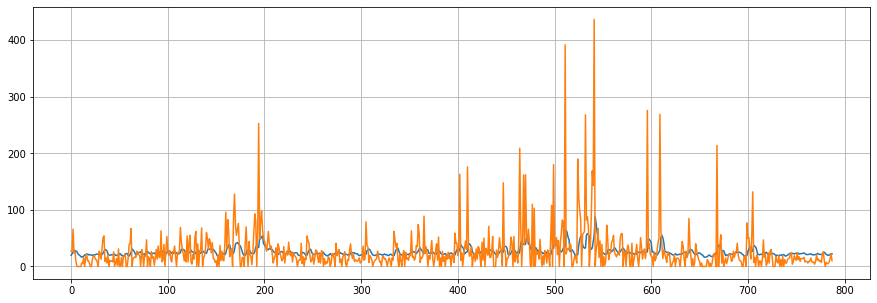

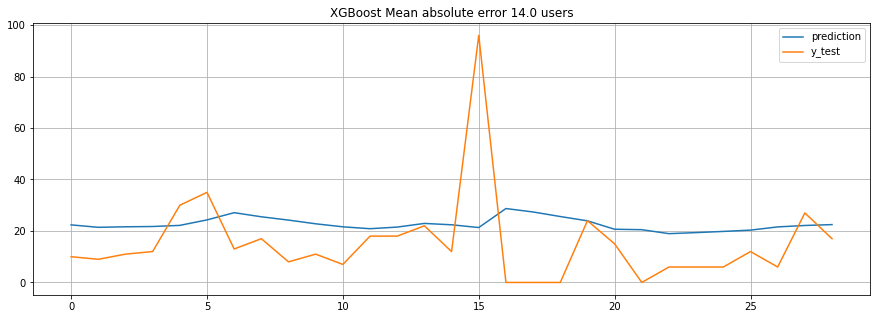

In [71]:
XGB_forecast(X_train, X_test, y_train, y_test, test_size=0.2, lag_start=1, lag_end=5)

In [72]:
len(prediction_no_promo)

29

In [73]:
sum(prediction_no_promo)

514.6722770785245

In [40]:
len(prediction_promo[:len(prediction_no_promo)])

29

In [41]:
sum(prediction_promo[:len(prediction_no_promo)])

614.4699800774174

In [42]:
( (614.4699800774174 - 514.6722770785245) / 614.4699800774174) * 100

16.241265844479386

# Стат. тест значимость отличий с промо и без промо

In [43]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
import scipy
import statsmodels

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
print("95% доверительный интервал для кол-ва продаж с промо", _tconfint_generic(prediction_promo.mean(), prediction_promo.std(),
                                                                       len(prediction_promo) - 1,
                                                                       0.05, 'two-sided'))

print("95% доверительный интервал для кол-ва продаж без промо", _tconfint_generic(prediction_no_promo.mean(), prediction_no_promo.std(),
                                                                         len(prediction_no_promo) - 1,
                                                                         0.05, 'two-sided'))

95% доверительный интервал для кол-ва продаж с промо (12.705971629212584, 30.759387158764646)
95% доверительный интервал для кол-ва продаж без промо (-1.925333046278844, 37.419972844797776)


Для того, чтобы использовать критерй Стьюдента для связанных выборок, давайте проверим, что распределение попарных разностей существенно не отличается от нормального.

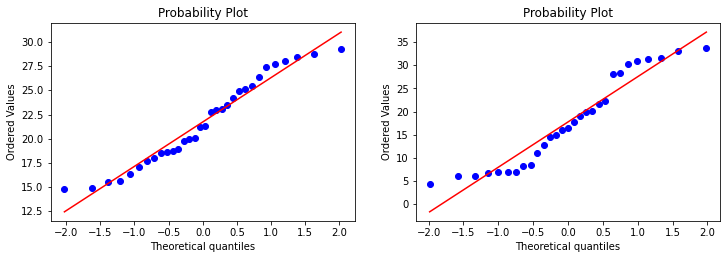

In [45]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(prediction_promo, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(prediction_no_promo, dist="norm", plot=pylab)
pylab.show()

Критерий Стьюдента:

𝐻0:

средние значения продаж одинаковы при проведении промо и без проведения промо

𝐻1:
не одинаковы.

In [51]:
len(prediction_promo), len(prediction_no_promo)

(32, 29)

In [53]:
stats.ttest_rel(prediction_promo[:len(prediction_no_promo)], prediction_no_promo)

Ttest_relResult(statistic=1.5155964854164201, pvalue=0.14083043593642447)

pvalue < уровня доверия 0.05 => отвергаем нулевую гипотезу в пользу 1й